In [1]:
import pandas as pd
import numpy as np
import os
import re
import json
import pytz
import datetime
from simple_salesforce import Salesforce, SalesforceLogin, SFType
import seaborn as sns
import matplotlib.pyplot as plt

import presto  # import prestosql python client
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
warnings.simplefilter('ignore', InsecureRequestWarning)

In [2]:
logininfo = json.load(open('/ghds/groups/labdesk/bshih/salesforce_login.json'))

username = logininfo['username']
password = logininfo['password']
security_token = logininfo['security_token']
domain = 'login'

sf = Salesforce(username=username, password=password, security_token=security_token)

In [3]:
uid = "_svc_acs_presto"
pwd = "em6qF7Gp8E9ECYcKx3gHZ#v$H@pzT7AX3uCJp%5wesKE%VD6gZaCB8*rZ2zNgMKdPkuetSJph2H&H2eadbfCkeB3tBbUqcM^Sj5k"

conn = presto.dbapi.connect(host='acs-exports.bi.ghdna.io',
                            port=8446,
                            user='_svc_acs_presto',
                            catalog='hive',
                            schema='default',
                            http_scheme='https',
                            verify=False,
                            auth=presto.auth.BasicAuthentication(uid, pwd))
cur = conn.cursor()

In [4]:
rbp_srp = []
for r in cur.execute(
        '''SELECT CAST(json_extract(acs_default_cv19.public.operation_operation.input_data, '$.inventory["labware"]["RNA Buffer Plate ID"]') AS VARCHAR),
                  CAST(json_extract(acs_default_cv19.public.operation_operation.input_data, '$.retain_data["retain_plate"]') AS VARCHAR)
           FROM acs_default_cv19.public.operation_operation
           WHERE name = 'Scanning Swab'
        '''):
    rbp_srp.append(r)
    
link = pd.DataFrame(rbp_srp, columns=['RBP', 'SRP']).dropna().drop_duplicates()

## All Negative Plates

In [5]:
master = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle')

master = master[master['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]
master = master[master['run_sample_id'].str.startswith(('G', 'H'), na=False)]
master = master[~master['run_sample_id'].str.startswith('Ht', na=False)]

master['RBP'] = master['pos_tube_rack'].str.extract(r'(.*?):.*')
master['Date'] = pd.to_datetime(master['runid'].str[:6], yearfirst=True)
master = master.merge(link, left_on='RBP', right_on='RBP', how='left').dropna(subset=['SRP'])

master['total_not_detected'] = master['call'].map({'not_detected': 1,
                                                   'detected': 0,
                                                   'no_call': 0})
master['num_of_samples'] = master['sample_type'].map({'Sample': 1})

srp = master.groupby('RBP', sort=False).agg({'num_of_samples': 'sum',
                                             'total_not_detected': 'sum',
                                             'SRP': 'max',
                                             'Date': 'max'})

srp = srp[(srp['num_of_samples'] == srp['total_not_detected']) & (srp['total_not_detected'] > 70)]\
    .reset_index().sort_values(['Date', 'SRP'], ascending=[False, True])

srp.head(15)

,RBP,num_of_samples,total_not_detected,SRP,Date
336,RBP201214A169,92,92,SRP200909A195,2021-03-09
338,RBP201214A155,92,92,SRP200909A202,2021-03-09
337,RBP201214A168,92,92,SRP200909A207,2021-03-09
183,RBP201214A203,92,92,SRP200909A197,2021-03-06
202,RBP201214A235,92,92,SRP200909A119,2021-03-03
201,RBP201214A234,92,92,SRP200909A123,2021-03-03
165,RBP201214A244,71,71,SRP200909A128,2021-03-02
164,RBP201214A177,92,92,SRP200909A196,2021-03-02
104,RBP201214A104,92,92,SRP200909A162,2021-02-27
335,RBP201214A108,92,92,SRP200909A163,2021-02-26


#### SRP with Run Sample ID for PQ

In [6]:
SRP = ['SRP200910A107', 'SRP200910A104', 'SRP200910A210', 'SRP200910A198',
       'SRP200910A204', 'SRP200910A208', 'SRP200910A203', 'SRP200910A133',
       'SRP200901A344', 'SRP200910A170', 'SRP200910A185', 'SRP200910A175']

In [7]:
master[master['SRP'].isin(SRP)].sort_values(by=['SRP', 'RBP']).loc[:, ['SRP', 'run_sample_id']]

,SRP,run_sample_id
73363,SRP200901A344,HBR0723
73364,SRP200901A344,HBT0053
73365,SRP200901A344,HBJ0816
73366,SRP200901A344,HBQ0211
73367,SRP200901A344,HBT0389
...,...,...
94491,SRP200910A210,HBQ0872
94492,SRP200910A210,HBK1148
94493,SRP200910A210,HBT0901
94494,SRP200910A210,HBX0595


# >20K G19 Score Samples Various Sites
 - Did not use SRP200909A025, could not find

In [8]:
high_g19 = master.query("median_covid_ratio > 20 & median_covid_ratio < 500").dropna(axis=1, how='all').sort_values(by='Date', ascending=False).iloc[:70, :]
accession = pd.read_csv('/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_accession.csv')

In [9]:
site_names = []
for i in high_g19['run_sample_id'].unique():
    site_names.extend(sf.query_all(f"SELECT GH_Sample_ID__c, Site_Name__c\
                                     FROM Order WHERE GH_Sample_ID__c = '{i}'").get('records'))

dataframe = pd.DataFrame(site_names)
df = dataframe.drop(columns='attributes').rename(columns={'GH_Sample_ID__c': 'run_sample_id',
                                                          'Site_Name__c': 'Site Name'})

In [10]:
barcode = {}
for i,j in zip(high_g19['run_sample_id'], high_g19['SRP']):
    for r in cur.execute(
            f'''SELECT json_extract(acs_default_cv19.public.operation_operation.input_data, '$.retain_data.sample_retain_map.{i}')
               FROM acs_default_cv19.public.operation_operation
               WHERE CAST(json_extract(acs_default_cv19.public.operation_operation.input_data, '$.retain_data["retain_plate"]') AS VARCHAR) = '{j}'
            '''):
        barcode[i] = json.loads(r[0])

retain_barcode = pd.DataFrame.from_dict(barcode).transpose().reset_index().rename(columns={'index':'run_sample_id'})

In [11]:
sites = high_g19.merge(df, left_on='run_sample_id', right_on='run_sample_id', how='left').merge(retain_barcode, left_on='run_sample_id', right_on='run_sample_id', how='left').merge(accession, left_on='run_sample_id', right_on='run_sample_id', how='left').sort_values(by='Site Name')
sites[sites['Site Name'] != 'Healing Grove'].sort_values(by=['runid', 'SRP'], ascending=[False, True]).loc[:, ['run_sample_id',
                                                                                                               'median_covid_ratio',
                                                                                                               'RBP',
                                                                                                               'Date',
                                                                                                               'SRP',
                                                                                                               'Site Name',
                                                                                                               'retain_barcode',
                                                                                                               'retain_position',
                                                                                                               'accession_date']]

,run_sample_id,median_covid_ratio,RBP,Date,SRP,Site Name,retain_barcode,retain_position,accession_date
0,HDU0430,49.65899,RBP201214A164,2021-03-09,SRP200909A201,Delaware State University,4052378705,B2,"3/9/2021, 11:41 AM"
1,HDM1173,34.39091,RBP201214A161,2021-03-03,SRP200909A125,Guardant Health PWN,4052382803,G8,"3/3/2021, 11:08 AM"
10,HDS1502,119.62757,RBP201214A213,2021-02-23,SRP200909A509,Delaware State University,4052393737,F10,"2/23/2021, 12:14 PM"
9,HDS0832,37.64570,RBP201214A004,2021-02-23,SRP200909A513,Delaware State University,4052439607,E4,"2/23/2021, 12:15 PM"
15,HDS0500,167.35418,RBP201214A097,2021-02-17,SRP200909A282,Delaware State University,4052373646,D7,"2/17/2021, 1:01 PM"
16,HDS0035,179.67840,RBP201214A099,2021-02-17,SRP200909A283,Delaware State University,4052390136,B9,"2/17/2021, 1:01 PM"
18,HDS0589,224.42708,RBP201214A047,2021-02-13,SRP200909A229,Delaware State University,4052308454,C11,"2/13/2021, 12:18 PM"
17,HDM0513,205.85600,RBP201214A188,2021-02-13,SRP200909A240,Delaware State University,4052331797,E2,"2/13/2021, 10:01 AM"
20,HDL0189,462.23881,RBP201214A048,2021-02-13,SRP200909A328,Delaware State University,4052427793,D10,"2/13/2021, 12:08 PM"
24,HD60459,167.62799,RBP201214A145,2021-02-09,SRP200909A275,Delaware State University,4052304109,A10,"2/9/2021, 9:54 AM"


In [12]:
sites[sites['Site Name'] == 'Healing Grove'].query("SRP != 'SRP200909A025'").sort_values(by=['runid', 'SRP', 'retain_barcode'], ascending=[False, True, True]).loc[:, ['run_sample_id',
                                                                                                                                                                       'median_covid_ratio',
                                                                                                                                                                       'RBP',
                                                                                                                                                                       'Date',
                                                                                                                                                                       'SRP',
                                                                                                                                                                       'Site Name',
                                                                                                                                                                       'retain_barcode',
                                                                                                                                                                       'retain_position',
                                                                                                                                                                       'accession_date']]

,run_sample_id,median_covid_ratio,RBP,Date,SRP,Site Name,retain_barcode,retain_position,accession_date
2,HDH2985,447.94774,RBP201214A178,2021-03-02,SRP200909A183,Healing Grove,4052278488,B9,"3/2/2021, 10:25 AM"
3,HDH2950,23.51344,RBP201214A178,2021-03-02,SRP200909A183,Healing Grove,4052278536,F9,"3/2/2021, 10:25 AM"
4,HDH1909,103.95857,RBP201214A221,2021-02-27,SRP200909A165,Healing Grove,4052285231,D8,"2/27/2021, 12:48 PM"
5,HDH2604,454.89017,RBP201214A221,2021-02-27,SRP200909A165,Healing Grove,4052285240,E5,"2/27/2021, 12:46 PM"
6,HDH2000,28.73303,RBP201214A227,2021-02-25,SRP200909A113,Healing Grove,4052465751,G12,"2/25/2021, 10:18 AM"
7,HDH1655,74.70651,RBP201214A081,2021-02-25,SRP200909A151,Healing Grove,4052380431,A12,"2/25/2021, 10:18 AM"
8,HDH2841,31.27934,RBP201214A257,2021-02-23,SRP200909A514,Healing Grove,4052439724,G1,"2/23/2021, 10:31 AM"
12,HDH2725,31.33368,RBP201214A031,2021-02-18,SRP200909A309,Healing Grove,4052368958,E11,"2/18/2021, 9:26 AM"
11,HDK0377,81.23536,RBP201214A031,2021-02-18,SRP200909A309,Healing Grove,4052368959,E12,"2/18/2021, 9:25 AM"
14,HDK0259,126.48007,RBP201214A076,2021-02-18,SRP200909A313,Healing Grove,4052374311,C12,"2/18/2021, 9:26 AM"


In [13]:
low_g19 = master.query("median_covid_ratio > 0.01 & median_covid_ratio < 1").dropna(axis=1, how='all').sort_values(by='Date', ascending=False).iloc[:70, :]

In [14]:
low_site_names = []
for i in low_g19['run_sample_id'].unique():
    low_site_names.extend(sf.query_all(f"SELECT GH_Sample_ID__c, Site_Name__c\
                                     FROM Order WHERE GH_Sample_ID__c = '{i}'").get('records'))

dataframe_low = pd.DataFrame(low_site_names)
df_low = dataframe_low.drop(columns='attributes').rename(columns={'GH_Sample_ID__c': 'run_sample_id',
                                                          'Site_Name__c': 'Site Name'})

In [15]:
barcode_low = {}
for i,j in zip(low_g19['run_sample_id'], low_g19['SRP']):
    for r in cur.execute(
            f'''SELECT json_extract(acs_default_cv19.public.operation_operation.input_data, '$.retain_data.sample_retain_map.{i}')
               FROM acs_default_cv19.public.operation_operation
               WHERE CAST(json_extract(acs_default_cv19.public.operation_operation.input_data, '$.retain_data["retain_plate"]') AS VARCHAR) = '{j}'
            '''):
        barcode_low[i] = json.loads(r[0])

retain_barcode_low = pd.DataFrame.from_dict(barcode_low).transpose().reset_index().rename(columns={'index':'run_sample_id'})

In [16]:
sites_low = low_g19.merge(df_low, left_on='run_sample_id', right_on='run_sample_id', how='left').merge(retain_barcode_low, left_on='run_sample_id', right_on='run_sample_id', how='left').merge(accession, left_on='run_sample_id', right_on='run_sample_id', how='left').sort_values(by='Site Name')
sites_low[sites_low['Site Name'] != 'Healing Grove'].sort_values(by=['runid', 'SRP'], ascending=[False, True]).loc[:, ['run_sample_id',
                                                                                                               'median_covid_ratio',
                                                                                                               'RBP',
                                                                                                               'Date',
                                                                                                               'SRP',
                                                                                                               'Site Name',
                                                                                                               'retain_barcode',
                                                                                                               'retain_position',
                                                                                                               'accession_date']]

,run_sample_id,median_covid_ratio,RBP,Date,SRP,Site Name,retain_barcode,retain_position,accession_date
7,HDM1876,0.06153,RBP201214A166,2021-03-09,SRP200909A173,Lincoln University,4052262323,G8,"3/9/2021, 11:51 AM"
8,HDJ0087,0.08424,RBP201214A164,2021-03-09,SRP200909A201,Lincoln University,4052378771,G8,"3/9/2021, 11:46 AM"
9,HDL1731,0.42830,RBP201214A204,2021-03-06,SRP200909A203,Delaware State University,4052378561,F2,"3/6/2021, 11:08 AM"
12,HDL1962,0.05719,RBP201214A207,2021-03-05,SRP200909A175,Lincoln University,4052262469,C10,"3/5/2021, 11:17 AM"
10,HDQ1666,0.27094,RBP201214A209,2021-03-05,SRP200909A180,Delaware State University,4052264487,C12,"3/5/2021, 11:27 AM"
13,HDW0208,0.03731,RBP201214A210,2021-03-05,SRP200909A181,Delaware State University,4052276922,H3,"3/5/2021, 11:26 AM"
11,HDV1875,0.25435,RBP201214A208,2021-03-05,SRP200909A211,Delaware State University,4052377343,H8,"3/5/2021, 11:19 AM"
14,HDV0393,0.03613,RBP201214A232,2021-03-03,SRP200909A189,Delaware State University,4052274165,B6,"3/3/2021, 11:08 AM"
19,HDY0577,0.02373,RBP201214A178,2021-03-02,SRP200909A183,Guardant Health,4052278509,D6,"3/2/2021, 10:13 AM"
17,HDL0964,0.71506,RBP201214A180,2021-03-02,SRP200909A192,Lincoln University,4052268007,A4,"3/2/2021, 10:32 AM"


## >30% Positive FAST Clinical Concordance

In [17]:
salesforce = pd.read_csv(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_tat.csv')

master['total_detected'] = master['call'].map({'not_detected': 0,
                                               'detected': 1,
                                               'no_call': 0})

labels = ['0-0.01', '0.01-1', '1-10', '10-100', '>100']
master['category'] = pd.cut(master['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(master.category)
master = pd.concat([master, dummies], axis=1).dropna(how='all', axis=1)

binning = master.groupby('RBP', sort=False).agg({'num_of_samples': 'sum',
                                                 'total_detected': 'sum',
                                                 'SRP': 'max',
                                                 'Date': 'max',
                                                 '0-0.01': 'sum',
                                                 '0.01-1': 'sum',
                                                 '1-10': 'sum',
                                                 '10-100': 'sum',
                                                 '>100': 'sum'})

binning = binning[(binning['total_detected'] > 10) & (binning['Date'] > '2020-10-01') & (binning['Date'] < '2020-12-31')
                  ].reset_index().sort_values(['Date', 'SRP'], ascending=[False, True])

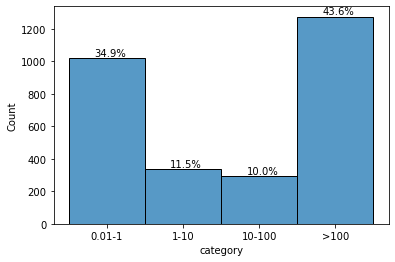

In [18]:
ax = sns.histplot(data=master.query("category != '0-0.01'"), x='category')

total = len(master.query("category != '0-0.01'"))
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/3
        y = p.get_y() + p.get_height() + 13
        ax.annotate(percentage, (x, y))

plt.show()

In [19]:
master.iloc[:, 15:].sum()

total_not_detected    90411
num_of_samples        94256
total_detected         2924
0-0.01                91332
0.01-1                 1021
1-10                    336
10-100                  292
>100                   1275
dtype: int64

In [20]:
pd.read_pickle('/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle')

,runid,run_sample_id,sample_type,pos_tube_rack,parameter_set,replicates_count,replicates_detected,replicates_not_detected,replicates_no_call,median_covid_ratio,...,barcode,covid_count,rnase_count,spikein_count,unknown,lamp_barcode,coverage,read_count,covid_n2_count,covid_s2_count
0,201212_NB552398_0053_AHHGFGBGXG,HBU0161,Sample,RBP201112A099:G6,Guardant19-RTPCR,3.0,0.0,3.0,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201212_NB552398_0053_AHHGFGBGXG,HBU0410,Sample,RBP201112A099:C3,Guardant19-RTPCR,3.0,0.0,2.0,1.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201212_NB552398_0053_AHHGFGBGXG,HBU0517,Sample,RBP201112A099:C9,Guardant19-RTPCR,3.0,0.0,3.0,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201212_NB552398_0053_AHHGFGBGXG,HBV0045,Sample,RBP201112A099:A4,Guardant19-RTPCR,3.0,1.0,2.0,0.0,0.00018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201212_NB552398_0053_AHHGFGBGXG,HCB0688,Sample,RBP201112A099:C7,Guardant19-RTPCR,3.0,0.0,3.0,0.0,0.00004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,210309_NB552393_0061_AHNVV2BGXG,NTC2011240682,NTC,RBP201214A155:A1,Guardant19-RTPCR,3.0,0.0,3.0,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,210309_NB552393_0061_AHNVV2BGXG,POS2011250041,Positive,RBP201214A155:B1,Guardant19-RTPCR,3.0,3.0,0.0,0.0,0.58657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,210309_NB552393_0061_AHNVV2BGXG,Ht02447,Sample,RBP201214A152:C1,Guardant19-RTPCR,3.0,0.0,0.0,3.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,210309_NB552393_0061_AHNVV2BGXG,NTC2011240652,NTC,RBP201214A152:A1,Guardant19-RTPCR,3.0,0.0,3.0,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
binning.sort_values(by=['Date', 'RBP'], ascending=[True, True])

,RBP,num_of_samples,total_detected,SRP,Date,0-0.01,0.01-1,1-10,10-100,>100
3,RBP200828A305,87,12,SRP200901A349,2020-10-20,75,2,2,0,8
45,RBP200828A123,92,13,SRP200910A127,2020-10-27,79,3,0,4,6
26,RBP201022A161,92,12,SRP201026A134,2020-11-07,80,4,5,1,2
25,RBP201022A115,87,30,SRP201026A097,2020-11-10,57,15,2,2,11
44,RBP201022A028,63,14,SRP201026A224,2020-11-11,49,2,1,3,8
43,RBP201022A118,92,16,SRP201026A091,2020-11-14,76,5,4,2,5
38,RBP201022A047,92,13,SRP200910A022,2020-11-17,79,4,3,2,4
39,RBP201022A050,92,20,SRP200910A162,2020-11-17,72,4,2,1,13
40,RBP201022A040,92,13,SRP200910A010,2020-11-19,79,1,3,2,7
41,RBP201022A063,92,16,SRP200910A066,2020-11-21,76,6,4,1,5


In [22]:
RBP = binning.RBP.unique()
binning.sum()['total_detected']

912

In [23]:
only_pos = master[(master['total_detected'] == 1) & (master['Date'] > '2020-10-01') & (master['RBP'].isin(RBP))
                  ].sort_values(by=['run_sample_id', 'Date'], ascending=False)
only_pos = only_pos.merge(
    salesforce, left_on='run_sample_id', right_on='run_sample_id', how='left')
# only_pos.to_csv('retain_plates.csv', index=False)

In [24]:
len(only_pos)

912